### the plan:
1. set up a small sample with 3 classes, 2400 training and 600 testing
2. check we can load/print svgs
3. check keras datagen works with trivial classifier
4. try larger convnet?
    - are larger filters worthwhile?
5. try vgg16 batchnorm insertion trick?

In [17]:
import os
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

import keras
from keras.optimizers import rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
from keras import backend as K
import glob
import shutil

import tensorflow as tf

%matplotlib inline

In [2]:
# verify if you are using gpu
# this will print to console output
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
tf.__version__

'1.0.1'

### download data

In [4]:
!wget http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip

--2017-04-12 13:35:28--  http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
Resolving cybertron.cg.tu-berlin.de (cybertron.cg.tu-berlin.de)... 130.149.80.52
Connecting to cybertron.cg.tu-berlin.de (cybertron.cg.tu-berlin.de)|130.149.80.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 550098987 (525M) [application/zip]
Saving to: ‘sketches_png.zip’

sketches_png.zip    100%[===================>] 524.62M  16.1MB/s    in 53s     

2017-04-12 13:36:21 (9.94 MB/s) - ‘sketches_png.zip’ saved [550098987/550098987]



In [6]:
!unzip sketches_png.zip

Archive:  sketches_png.zip
   creating: png/
   creating: png/airplane/
  inflating: png/airplane/1.png      
  inflating: png/airplane/10.png     
  inflating: png/airplane/11.png     
  inflating: png/airplane/12.png     
  inflating: png/airplane/13.png     
  inflating: png/airplane/14.png     
  inflating: png/airplane/15.png     
  inflating: png/airplane/16.png     
  inflating: png/airplane/17.png     
  inflating: png/airplane/18.png     
  inflating: png/airplane/19.png     
  inflating: png/airplane/2.png      
  inflating: png/airplane/20.png     
  inflating: png/airplane/21.png     
  inflating: png/airplane/22.png     
  inflating: png/airplane/23.png     
  inflating: png/airplane/24.png     
  inflating: png/airplane/25.png     
  inflating: png/airplane/26.png     
  inflating: png/airplane/27.png     
  inflating: png/airplane/28.png     
  inflating: png/airplane/29.png     
  inflating: png/airplane/3.png      
  inflating: png/airplane/30.png     
  inflating: png

  inflating: png/ant/318.png         
  inflating: png/ant/319.png         
  inflating: png/ant/320.png         
   creating: png/apple/
  inflating: png/apple/321.png       
  inflating: png/apple/322.png       
  inflating: png/apple/323.png       
  inflating: png/apple/324.png       
  inflating: png/apple/325.png       
  inflating: png/apple/326.png       
  inflating: png/apple/327.png       
  inflating: png/apple/328.png       
  inflating: png/apple/329.png       
  inflating: png/apple/330.png       
  inflating: png/apple/331.png       
  inflating: png/apple/332.png       
  inflating: png/apple/333.png       
  inflating: png/apple/334.png       
  inflating: png/apple/335.png       
  inflating: png/apple/336.png       
  inflating: png/apple/337.png       
  inflating: png/apple/338.png       
  inflating: png/apple/339.png       
  inflating: png/apple/340.png       
  inflating: png/apple/341.png       
  inflating: png/apple/342.png       
  inflating: png/apple/343

  inflating: png/axe/701.png         
  inflating: png/axe/702.png         
  inflating: png/axe/703.png         
  inflating: png/axe/704.png         
  inflating: png/axe/705.png         
  inflating: png/axe/706.png         
  inflating: png/axe/707.png         
  inflating: png/axe/708.png         
  inflating: png/axe/709.png         
  inflating: png/axe/710.png         
  inflating: png/axe/711.png         
  inflating: png/axe/712.png         
  inflating: png/axe/713.png         
  inflating: png/axe/714.png         
  inflating: png/axe/715.png         
  inflating: png/axe/716.png         
  inflating: png/axe/717.png         
  inflating: png/axe/718.png         
  inflating: png/axe/719.png         
  inflating: png/axe/720.png         
   creating: png/backpack/
  inflating: png/backpack/721.png    
  inflating: png/backpack/722.png    
  inflating: png/backpack/723.png    
  inflating: png/backpack/724.png    
  inflating: png/backpack/725.png    
  inflating: png/backpa

  inflating: png/basket/1050.png     
  inflating: png/basket/1051.png     
  inflating: png/basket/1052.png     
  inflating: png/basket/1053.png     
  inflating: png/basket/1054.png     
  inflating: png/basket/1055.png     
  inflating: png/basket/1056.png     
  inflating: png/basket/1057.png     
  inflating: png/basket/1058.png     
  inflating: png/basket/1059.png     
  inflating: png/basket/1060.png     
  inflating: png/basket/1061.png     
  inflating: png/basket/1062.png     
  inflating: png/basket/1063.png     
  inflating: png/basket/1064.png     
  inflating: png/basket/1065.png     
  inflating: png/basket/1066.png     
  inflating: png/basket/1067.png     
  inflating: png/basket/1068.png     
  inflating: png/basket/1069.png     
  inflating: png/basket/1070.png     
  inflating: png/basket/1071.png     
  inflating: png/basket/1072.png     
  inflating: png/basket/1073.png     
  inflating: png/basket/1074.png     
  inflating: png/basket/1075.png     
  inflating:

  inflating: png/bee/1395.png        
  inflating: png/bee/1396.png        
  inflating: png/bee/1397.png        
  inflating: png/bee/1398.png        
  inflating: png/bee/1399.png        
  inflating: png/bee/1400.png        
  inflating: png/bee/1401.png        
  inflating: png/bee/1402.png        
  inflating: png/bee/1403.png        
  inflating: png/bee/1404.png        
  inflating: png/bee/1405.png        
  inflating: png/bee/1406.png        
  inflating: png/bee/1407.png        
  inflating: png/bee/1408.png        
  inflating: png/bee/1409.png        
  inflating: png/bee/1410.png        
  inflating: png/bee/1411.png        
  inflating: png/bee/1412.png        
  inflating: png/bee/1413.png        
  inflating: png/bee/1414.png        
  inflating: png/bee/1415.png        
  inflating: png/bee/1416.png        
  inflating: png/bee/1417.png        
  inflating: png/bee/1418.png        
  inflating: png/bee/1419.png        
  inflating: png/bee/1420.png        
  inflating:

  inflating: png/bench/1616.png      
  inflating: png/bench/1617.png      
  inflating: png/bench/1618.png      
  inflating: png/bench/1619.png      
  inflating: png/bench/1620.png      
  inflating: png/bench/1621.png      
  inflating: png/bench/1622.png      
  inflating: png/bench/1623.png      
  inflating: png/bench/1624.png      
  inflating: png/bench/1625.png      
  inflating: png/bench/1626.png      
  inflating: png/bench/1627.png      
  inflating: png/bench/1628.png      
  inflating: png/bench/1629.png      
  inflating: png/bench/1630.png      
  inflating: png/bench/1631.png      
  inflating: png/bench/1632.png      
  inflating: png/bench/1633.png      
  inflating: png/bench/1634.png      
  inflating: png/bench/1635.png      
  inflating: png/bench/1636.png      
  inflating: png/bench/1637.png      
  inflating: png/bench/1638.png      
  inflating: png/bench/1639.png      
  inflating: png/bench/1640.png      
  inflating: png/bench/1641.png      
  inflating:

  inflating: png/book/1958.png       
  inflating: png/book/1959.png       
  inflating: png/book/1960.png       
  inflating: png/book/1961.png       
  inflating: png/book/1962.png       
  inflating: png/book/1963.png       
  inflating: png/book/1964.png       
  inflating: png/book/1965.png       
  inflating: png/book/1966.png       
  inflating: png/book/1967.png       
  inflating: png/book/1968.png       
  inflating: png/book/1969.png       
  inflating: png/book/1970.png       
  inflating: png/book/1971.png       
  inflating: png/book/1972.png       
  inflating: png/book/1973.png       
  inflating: png/book/1974.png       
  inflating: png/book/1975.png       
  inflating: png/book/1976.png       
  inflating: png/book/1977.png       
  inflating: png/book/1978.png       
  inflating: png/book/1979.png       
  inflating: png/book/1980.png       
  inflating: png/book/1981.png       
  inflating: png/book/1982.png       
  inflating: png/book/1983.png       
  inflating:

  inflating: png/brain/2333.png      
  inflating: png/brain/2334.png      
  inflating: png/brain/2335.png      
  inflating: png/brain/2336.png      
  inflating: png/brain/2337.png      
  inflating: png/brain/2338.png      
  inflating: png/brain/2339.png      
  inflating: png/brain/2340.png      
  inflating: png/brain/2341.png      
  inflating: png/brain/2342.png      
  inflating: png/brain/2343.png      
  inflating: png/brain/2344.png      
  inflating: png/brain/2345.png      
  inflating: png/brain/2346.png      
  inflating: png/brain/2347.png      
  inflating: png/brain/2348.png      
  inflating: png/brain/2349.png      
  inflating: png/brain/2350.png      
  inflating: png/brain/2351.png      
  inflating: png/brain/2352.png      
  inflating: png/brain/2353.png      
  inflating: png/brain/2354.png      
  inflating: png/brain/2355.png      
  inflating: png/brain/2356.png      
  inflating: png/brain/2357.png      
  inflating: png/brain/2358.png      
  inflating:

  inflating: png/bus/2653.png        
  inflating: png/bus/2654.png        
  inflating: png/bus/2655.png        
  inflating: png/bus/2656.png        
  inflating: png/bus/2657.png        
  inflating: png/bus/2658.png        
  inflating: png/bus/2659.png        
  inflating: png/bus/2660.png        
  inflating: png/bus/2661.png        
  inflating: png/bus/2662.png        
  inflating: png/bus/2663.png        
  inflating: png/bus/2664.png        
  inflating: png/bus/2665.png        
  inflating: png/bus/2666.png        
  inflating: png/bus/2667.png        
  inflating: png/bus/2668.png        
  inflating: png/bus/2669.png        
  inflating: png/bus/2670.png        
  inflating: png/bus/2671.png        
  inflating: png/bus/2672.png        
  inflating: png/bus/2673.png        
  inflating: png/bus/2674.png        
  inflating: png/bus/2675.png        
  inflating: png/bus/2676.png        
  inflating: png/bus/2677.png        
  inflating: png/bus/2678.png        
  inflating:

  inflating: png/cabinet/2955.png    
  inflating: png/cabinet/2956.png    
  inflating: png/cabinet/2957.png    
  inflating: png/cabinet/2958.png    
  inflating: png/cabinet/2959.png    
  inflating: png/cabinet/2960.png    
   creating: png/cactus/
  inflating: png/cactus/2961.png     
  inflating: png/cactus/2962.png     
  inflating: png/cactus/2963.png     
  inflating: png/cactus/2964.png     
  inflating: png/cactus/2965.png     
  inflating: png/cactus/2966.png     
  inflating: png/cactus/2967.png     
  inflating: png/cactus/2968.png     
  inflating: png/cactus/2969.png     
  inflating: png/cactus/2970.png     
  inflating: png/cactus/2971.png     
  inflating: png/cactus/2972.png     
  inflating: png/cactus/2973.png     
  inflating: png/cactus/2974.png     
  inflating: png/cactus/2975.png     
  inflating: png/cactus/2976.png     
  inflating: png/cactus/2977.png     
  inflating: png/cactus/2978.png     
  inflating: png/cactus/2979.png     
  inflating: png/cactus/2

  inflating: png/camel/3252.png      
  inflating: png/camel/3253.png      
  inflating: png/camel/3254.png      
  inflating: png/camel/3255.png      
  inflating: png/camel/3256.png      
  inflating: png/camel/3257.png      
  inflating: png/camel/3258.png      
  inflating: png/camel/3259.png      
  inflating: png/camel/3260.png      
  inflating: png/camel/3261.png      
  inflating: png/camel/3262.png      
  inflating: png/camel/3263.png      
  inflating: png/camel/3264.png      
  inflating: png/camel/3265.png      
  inflating: png/camel/3266.png      
  inflating: png/camel/3267.png      
  inflating: png/camel/3268.png      
  inflating: png/camel/3269.png      
  inflating: png/camel/3270.png      
  inflating: png/camel/3271.png      
  inflating: png/camel/3272.png      
  inflating: png/camel/3273.png      
  inflating: png/camel/3274.png      
  inflating: png/camel/3275.png      
  inflating: png/camel/3276.png      
  inflating: png/camel/3277.png      
  inflating:

  inflating: png/car (sedan)/3654.png  
  inflating: png/car (sedan)/3655.png  
  inflating: png/car (sedan)/3656.png  
  inflating: png/car (sedan)/3657.png  
  inflating: png/car (sedan)/3658.png  
  inflating: png/car (sedan)/3659.png  
  inflating: png/car (sedan)/3660.png  
  inflating: png/car (sedan)/3661.png  
  inflating: png/car (sedan)/3662.png  
  inflating: png/car (sedan)/3663.png  
  inflating: png/car (sedan)/3664.png  
  inflating: png/car (sedan)/3665.png  
  inflating: png/car (sedan)/3666.png  
  inflating: png/car (sedan)/3667.png  
  inflating: png/car (sedan)/3668.png  
  inflating: png/car (sedan)/3669.png  
  inflating: png/car (sedan)/3670.png  
  inflating: png/car (sedan)/3671.png  
  inflating: png/car (sedan)/3672.png  
  inflating: png/car (sedan)/3673.png  
  inflating: png/car (sedan)/3674.png  
  inflating: png/car (sedan)/3675.png  
  inflating: png/car (sedan)/3676.png  
  inflating: png/car (sedan)/3677.png  
  inflating: png/car (sedan)/3678.png  


  inflating: png/cell phone/3980.png  
  inflating: png/cell phone/3981.png  
  inflating: png/cell phone/3982.png  
  inflating: png/cell phone/3983.png  
  inflating: png/cell phone/3984.png  
  inflating: png/cell phone/3985.png  
  inflating: png/cell phone/3986.png  
  inflating: png/cell phone/3987.png  
  inflating: png/cell phone/3988.png  
  inflating: png/cell phone/3989.png  
  inflating: png/cell phone/3990.png  
  inflating: png/cell phone/3991.png  
  inflating: png/cell phone/3992.png  
  inflating: png/cell phone/3993.png  
  inflating: png/cell phone/3994.png  
  inflating: png/cell phone/3995.png  
  inflating: png/cell phone/3996.png  
  inflating: png/cell phone/3997.png  
  inflating: png/cell phone/3998.png  
  inflating: png/cell phone/3999.png  
  inflating: png/cell phone/4000.png  
   creating: png/chair/
  inflating: png/chair/4001.png      
  inflating: png/chair/4002.png      
  inflating: png/chair/4003.png      
  inflating: png/chair/4004.png      
  inf

  inflating: png/cloud/4338.png      
  inflating: png/cloud/4339.png      
  inflating: png/cloud/4340.png      
  inflating: png/cloud/4341.png      
  inflating: png/cloud/4342.png      
  inflating: png/cloud/4343.png      
  inflating: png/cloud/4344.png      
  inflating: png/cloud/4345.png      
  inflating: png/cloud/4346.png      
  inflating: png/cloud/4347.png      
  inflating: png/cloud/4348.png      
  inflating: png/cloud/4349.png      
  inflating: png/cloud/4350.png      
  inflating: png/cloud/4351.png      
  inflating: png/cloud/4352.png      
  inflating: png/cloud/4353.png      
  inflating: png/cloud/4354.png      
  inflating: png/cloud/4355.png      
  inflating: png/cloud/4356.png      
  inflating: png/cloud/4357.png      
  inflating: png/cloud/4358.png      
  inflating: png/cloud/4359.png      
  inflating: png/cloud/4360.png      
  inflating: png/cloud/4361.png      
  inflating: png/cloud/4362.png      
  inflating: png/cloud/4363.png      
  inflating:

  inflating: png/computer monitor/4542.png  
  inflating: png/computer monitor/4543.png  
  inflating: png/computer monitor/4544.png  
  inflating: png/computer monitor/4545.png  
  inflating: png/computer monitor/4546.png  
  inflating: png/computer monitor/4547.png  
  inflating: png/computer monitor/4548.png  
  inflating: png/computer monitor/4549.png  
  inflating: png/computer monitor/4550.png  
  inflating: png/computer monitor/4551.png  
  inflating: png/computer monitor/4552.png  
  inflating: png/computer monitor/4553.png  
  inflating: png/computer monitor/4554.png  
  inflating: png/computer monitor/4555.png  
  inflating: png/computer monitor/4556.png  
  inflating: png/computer monitor/4557.png  
  inflating: png/computer monitor/4558.png  
  inflating: png/computer monitor/4559.png  
  inflating: png/computer monitor/4560.png  
   creating: png/computer-mouse/
  inflating: png/computer-mouse/4561.png  
  inflating: png/computer-mouse/4562.png  
  inflating: png/computer-

  inflating: png/cow/4742.png        
  inflating: png/cow/4743.png        
  inflating: png/cow/4744.png        
  inflating: png/cow/4745.png        
  inflating: png/cow/4746.png        
  inflating: png/cow/4747.png        
  inflating: png/cow/4748.png        
  inflating: png/cow/4749.png        
  inflating: png/cow/4750.png        
  inflating: png/cow/4751.png        
  inflating: png/cow/4752.png        
  inflating: png/cow/4753.png        
  inflating: png/cow/4754.png        
  inflating: png/cow/4755.png        
  inflating: png/cow/4756.png        
  inflating: png/cow/4757.png        
  inflating: png/cow/4758.png        
  inflating: png/cow/4759.png        
  inflating: png/cow/4760.png        
  inflating: png/cow/4761.png        
  inflating: png/cow/4762.png        
  inflating: png/cow/4763.png        
  inflating: png/cow/4764.png        
  inflating: png/cow/4765.png        
  inflating: png/cow/4766.png        
  inflating: png/cow/4767.png        
  inflating:

  inflating: png/crown/5065.png      
  inflating: png/crown/5066.png      
  inflating: png/crown/5067.png      
  inflating: png/crown/5068.png      
  inflating: png/crown/5069.png      
  inflating: png/crown/5070.png      
  inflating: png/crown/5071.png      
  inflating: png/crown/5072.png      
  inflating: png/crown/5073.png      
  inflating: png/crown/5074.png      
  inflating: png/crown/5075.png      
  inflating: png/crown/5076.png      
  inflating: png/crown/5077.png      
  inflating: png/crown/5078.png      
  inflating: png/crown/5079.png      
  inflating: png/crown/5080.png      
  inflating: png/crown/5081.png      
  inflating: png/crown/5082.png      
  inflating: png/crown/5083.png      
  inflating: png/crown/5084.png      
  inflating: png/crown/5085.png      
  inflating: png/crown/5086.png      
  inflating: png/crown/5087.png      
  inflating: png/crown/5088.png      
  inflating: png/crown/5089.png      
  inflating: png/crown/5090.png      
  inflating:

  inflating: png/dog/5341.png        
  inflating: png/dog/5342.png        
  inflating: png/dog/5343.png        
  inflating: png/dog/5344.png        
  inflating: png/dog/5345.png        
  inflating: png/dog/5346.png        
  inflating: png/dog/5347.png        
  inflating: png/dog/5348.png        
  inflating: png/dog/5349.png        
  inflating: png/dog/5350.png        
  inflating: png/dog/5351.png        
  inflating: png/dog/5352.png        
  inflating: png/dog/5353.png        
  inflating: png/dog/5354.png        
  inflating: png/dog/5355.png        
  inflating: png/dog/5356.png        
  inflating: png/dog/5357.png        
  inflating: png/dog/5358.png        
  inflating: png/dog/5359.png        
  inflating: png/dog/5360.png        
   creating: png/dolphin/
  inflating: png/dolphin/5361.png    
  inflating: png/dolphin/5362.png    
  inflating: png/dolphin/5363.png    
  inflating: png/dolphin/5364.png    
  inflating: png/dolphin/5365.png    
  inflating: png/dolphin

  inflating: png/dragon/5705.png     
  inflating: png/dragon/5706.png     
  inflating: png/dragon/5707.png     
  inflating: png/dragon/5708.png     
  inflating: png/dragon/5709.png     
  inflating: png/dragon/5710.png     
  inflating: png/dragon/5711.png     
  inflating: png/dragon/5712.png     
  inflating: png/dragon/5713.png     
  inflating: png/dragon/5714.png     
  inflating: png/dragon/5715.png     
  inflating: png/dragon/5716.png     
  inflating: png/dragon/5717.png     
  inflating: png/dragon/5718.png     
  inflating: png/dragon/5719.png     
  inflating: png/dragon/5720.png     
  inflating: png/dragon/5721.png     
  inflating: png/dragon/5722.png     
  inflating: png/dragon/5723.png     
  inflating: png/dragon/5724.png     
  inflating: png/dragon/5725.png     
  inflating: png/dragon/5726.png     
  inflating: png/dragon/5727.png     
  inflating: png/dragon/5728.png     
  inflating: png/dragon/5729.png     
  inflating: png/dragon/5730.png     
  inflating:

  inflating: png/envelope/6073.png   
  inflating: png/envelope/6074.png   
  inflating: png/envelope/6075.png   
  inflating: png/envelope/6076.png   
  inflating: png/envelope/6077.png   
  inflating: png/envelope/6078.png   
  inflating: png/envelope/6079.png   
  inflating: png/envelope/6080.png   
   creating: png/eye/
  inflating: png/eye/6081.png        
  inflating: png/eye/6082.png        
  inflating: png/eye/6083.png        
  inflating: png/eye/6084.png        
  inflating: png/eye/6085.png        
  inflating: png/eye/6086.png        
  inflating: png/eye/6087.png        
  inflating: png/eye/6088.png        
  inflating: png/eye/6089.png        
  inflating: png/eye/6090.png        
  inflating: png/eye/6091.png        
  inflating: png/eye/6092.png        
  inflating: png/eye/6093.png        
  inflating: png/eye/6094.png        
  inflating: png/eye/6095.png        
  inflating: png/eye/6096.png        
  inflating: png/eye/6097.png        
  inflating: png/eye/6098.pn

  inflating: png/face/6281.png       
  inflating: png/face/6282.png       
  inflating: png/face/6283.png       
  inflating: png/face/6284.png       
  inflating: png/face/6285.png       
  inflating: png/face/6286.png       
  inflating: png/face/6287.png       
  inflating: png/face/6288.png       
  inflating: png/face/6289.png       
  inflating: png/face/6290.png       
  inflating: png/face/6291.png       
  inflating: png/face/6292.png       
  inflating: png/face/6293.png       
  inflating: png/face/6294.png       
  inflating: png/face/6295.png       
  inflating: png/face/6296.png       
  inflating: png/face/6297.png       
  inflating: png/face/6298.png       
  inflating: png/face/6299.png       
  inflating: png/face/6300.png       
  inflating: png/face/6301.png       
  inflating: png/face/6302.png       
  inflating: png/face/6303.png       
  inflating: png/face/6304.png       
  inflating: png/face/6305.png       
  inflating: png/face/6306.png       
  inflating:

  inflating: png/fish/6632.png       
  inflating: png/fish/6633.png       
  inflating: png/fish/6634.png       
  inflating: png/fish/6635.png       
  inflating: png/fish/6636.png       
  inflating: png/fish/6637.png       
  inflating: png/fish/6638.png       
  inflating: png/fish/6639.png       
  inflating: png/fish/6640.png       
   creating: png/flashlight/
  inflating: png/flashlight/6641.png  
  inflating: png/flashlight/6642.png  
  inflating: png/flashlight/6643.png  
  inflating: png/flashlight/6644.png  
  inflating: png/flashlight/6645.png  
  inflating: png/flashlight/6646.png  
  inflating: png/flashlight/6647.png  
  inflating: png/flashlight/6648.png  
  inflating: png/flashlight/6649.png  
  inflating: png/flashlight/6650.png  
  inflating: png/flashlight/6651.png  
  inflating: png/flashlight/6652.png  
  inflating: png/flashlight/6653.png  
  inflating: png/flashlight/6654.png  
  inflating: png/flashlight/6655.png  
  inflating: png/flashlight/6656.png  
  inf

  inflating: png/flower with stem/6843.png  
  inflating: png/flower with stem/6844.png  
  inflating: png/flower with stem/6845.png  
  inflating: png/flower with stem/6846.png  
  inflating: png/flower with stem/6847.png  
  inflating: png/flower with stem/6848.png  
  inflating: png/flower with stem/6849.png  
  inflating: png/flower with stem/6850.png  
  inflating: png/flower with stem/6851.png  
  inflating: png/flower with stem/6852.png  
  inflating: png/flower with stem/6853.png  
  inflating: png/flower with stem/6854.png  
  inflating: png/flower with stem/6855.png  
  inflating: png/flower with stem/6856.png  
  inflating: png/flower with stem/6857.png  
  inflating: png/flower with stem/6858.png  
  inflating: png/flower with stem/6859.png  
  inflating: png/flower with stem/6860.png  
  inflating: png/flower with stem/6861.png  
  inflating: png/flower with stem/6862.png  
  inflating: png/flower with stem/6863.png  
  inflating: png/flower with stem/6864.png  
  inflatin

  inflating: png/foot/7044.png       
  inflating: png/foot/7045.png       
  inflating: png/foot/7046.png       
  inflating: png/foot/7047.png       
  inflating: png/foot/7048.png       
  inflating: png/foot/7049.png       
  inflating: png/foot/7050.png       
  inflating: png/foot/7051.png       
  inflating: png/foot/7052.png       
  inflating: png/foot/7053.png       
  inflating: png/foot/7054.png       
  inflating: png/foot/7055.png       
  inflating: png/foot/7056.png       
  inflating: png/foot/7057.png       
  inflating: png/foot/7058.png       
  inflating: png/foot/7059.png       
  inflating: png/foot/7060.png       
  inflating: png/foot/7061.png       
  inflating: png/foot/7062.png       
  inflating: png/foot/7063.png       
  inflating: png/foot/7064.png       
  inflating: png/foot/7065.png       
  inflating: png/foot/7066.png       
  inflating: png/foot/7067.png       
  inflating: png/foot/7068.png       
  inflating: png/foot/7069.png       
  inflating:

  inflating: png/giraffe/7420.png    
  inflating: png/giraffe/7421.png    
  inflating: png/giraffe/7422.png    
  inflating: png/giraffe/7423.png    
  inflating: png/giraffe/7424.png    
  inflating: png/giraffe/7425.png    
  inflating: png/giraffe/7426.png    
  inflating: png/giraffe/7427.png    
  inflating: png/giraffe/7428.png    
  inflating: png/giraffe/7429.png    
  inflating: png/giraffe/7430.png    
  inflating: png/giraffe/7431.png    
  inflating: png/giraffe/7432.png    
  inflating: png/giraffe/7433.png    
  inflating: png/giraffe/7434.png    
  inflating: png/giraffe/7435.png    
  inflating: png/giraffe/7436.png    
  inflating: png/giraffe/7437.png    
  inflating: png/giraffe/7438.png    
  inflating: png/giraffe/7439.png    
  inflating: png/giraffe/7440.png    
   creating: png/grapes/
  inflating: png/grapes/7441.png     
  inflating: png/grapes/7442.png     
  inflating: png/grapes/7443.png     
  inflating: png/grapes/7444.png     
  inflating: png/grapes/7

  inflating: png/hamburger/7699.png  
  inflating: png/hamburger/7700.png  
  inflating: png/hamburger/7701.png  
  inflating: png/hamburger/7702.png  
  inflating: png/hamburger/7703.png  
  inflating: png/hamburger/7704.png  
  inflating: png/hamburger/7705.png  
  inflating: png/hamburger/7706.png  
  inflating: png/hamburger/7707.png  
  inflating: png/hamburger/7708.png  
  inflating: png/hamburger/7709.png  
  inflating: png/hamburger/7710.png  
  inflating: png/hamburger/7711.png  
  inflating: png/hamburger/7712.png  
  inflating: png/hamburger/7713.png  
  inflating: png/hamburger/7714.png  
  inflating: png/hamburger/7715.png  
  inflating: png/hamburger/7716.png  
  inflating: png/hamburger/7717.png  
  inflating: png/hamburger/7718.png  
  inflating: png/hamburger/7719.png  
  inflating: png/hamburger/7720.png  
  inflating: png/hamburger/7721.png  
  inflating: png/hamburger/7722.png  
  inflating: png/hamburger/7723.png  
  inflating: png/hamburger/7724.png  
  inflating:

  inflating: png/hat/8033.png        
  inflating: png/hat/8034.png        
  inflating: png/hat/8035.png        
  inflating: png/hat/8036.png        
  inflating: png/hat/8037.png        
  inflating: png/hat/8038.png        
  inflating: png/hat/8039.png        
  inflating: png/hat/8040.png        
  inflating: png/hat/8041.png        
  inflating: png/hat/8042.png        
  inflating: png/hat/8043.png        
  inflating: png/hat/8044.png        
  inflating: png/hat/8045.png        
  inflating: png/hat/8046.png        
  inflating: png/hat/8047.png        
  inflating: png/hat/8048.png        
  inflating: png/hat/8049.png        
  inflating: png/hat/8050.png        
  inflating: png/hat/8051.png        
  inflating: png/hat/8052.png        
  inflating: png/hat/8053.png        
  inflating: png/hat/8054.png        
  inflating: png/hat/8055.png        
  inflating: png/hat/8056.png        
  inflating: png/hat/8057.png        
  inflating: png/hat/8058.png        
  inflating:

  inflating: png/helicopter/8370.png  
  inflating: png/helicopter/8371.png  
  inflating: png/helicopter/8372.png  
  inflating: png/helicopter/8373.png  
  inflating: png/helicopter/8374.png  
  inflating: png/helicopter/8375.png  
  inflating: png/helicopter/8376.png  
  inflating: png/helicopter/8377.png  
  inflating: png/helicopter/8378.png  
  inflating: png/helicopter/8379.png  
  inflating: png/helicopter/8380.png  
  inflating: png/helicopter/8381.png  
  inflating: png/helicopter/8382.png  
  inflating: png/helicopter/8383.png  
  inflating: png/helicopter/8384.png  
  inflating: png/helicopter/8385.png  
  inflating: png/helicopter/8386.png  
  inflating: png/helicopter/8387.png  
  inflating: png/helicopter/8388.png  
  inflating: png/helicopter/8389.png  
  inflating: png/helicopter/8390.png  
  inflating: png/helicopter/8391.png  
  inflating: png/helicopter/8392.png  
  inflating: png/helicopter/8393.png  
  inflating: png/helicopter/8394.png  
  inflating: png/helicopt

  inflating: png/hourglass/8722.png  
  inflating: png/hourglass/8723.png  
  inflating: png/hourglass/8724.png  
  inflating: png/hourglass/8725.png  
  inflating: png/hourglass/8726.png  
  inflating: png/hourglass/8727.png  
  inflating: png/hourglass/8728.png  
  inflating: png/hourglass/8729.png  
  inflating: png/hourglass/8730.png  
  inflating: png/hourglass/8731.png  
  inflating: png/hourglass/8732.png  
  inflating: png/hourglass/8733.png  
  inflating: png/hourglass/8734.png  
  inflating: png/hourglass/8735.png  
  inflating: png/hourglass/8736.png  
  inflating: png/hourglass/8737.png  
  inflating: png/hourglass/8738.png  
  inflating: png/hourglass/8739.png  
  inflating: png/hourglass/8740.png  
  inflating: png/hourglass/8741.png  
  inflating: png/hourglass/8742.png  
  inflating: png/hourglass/8743.png  
  inflating: png/hourglass/8744.png  
  inflating: png/hourglass/8745.png  
  inflating: png/hourglass/8746.png  
  inflating: png/hourglass/8747.png  
  inflating:

  inflating: png/ice-cream-cone/8961.png  
  inflating: png/ice-cream-cone/8962.png  
  inflating: png/ice-cream-cone/8963.png  
  inflating: png/ice-cream-cone/8964.png  
  inflating: png/ice-cream-cone/8965.png  
  inflating: png/ice-cream-cone/8966.png  
  inflating: png/ice-cream-cone/8967.png  
  inflating: png/ice-cream-cone/8968.png  
  inflating: png/ice-cream-cone/8969.png  
  inflating: png/ice-cream-cone/8970.png  
  inflating: png/ice-cream-cone/8971.png  
  inflating: png/ice-cream-cone/8972.png  
  inflating: png/ice-cream-cone/8973.png  
  inflating: png/ice-cream-cone/8974.png  
  inflating: png/ice-cream-cone/8975.png  
  inflating: png/ice-cream-cone/8976.png  
  inflating: png/ice-cream-cone/8977.png  
  inflating: png/ice-cream-cone/8978.png  
  inflating: png/ice-cream-cone/8979.png  
  inflating: png/ice-cream-cone/8980.png  
  inflating: png/ice-cream-cone/8981.png  
  inflating: png/ice-cream-cone/8982.png  
  inflating: png/ice-cream-cone/8983.png  
  inflating

  inflating: png/keyboard/9315.png   
  inflating: png/keyboard/9316.png   
  inflating: png/keyboard/9317.png   
  inflating: png/keyboard/9318.png   
  inflating: png/keyboard/9319.png   
  inflating: png/keyboard/9320.png   
  inflating: png/keyboard/9321.png   
  inflating: png/keyboard/9322.png   
  inflating: png/keyboard/9323.png   
  inflating: png/keyboard/9324.png   
  inflating: png/keyboard/9325.png   
  inflating: png/keyboard/9326.png   
  inflating: png/keyboard/9327.png   
  inflating: png/keyboard/9328.png   
  inflating: png/keyboard/9329.png   
  inflating: png/keyboard/9330.png   
  inflating: png/keyboard/9331.png   
  inflating: png/keyboard/9332.png   
  inflating: png/keyboard/9333.png   
  inflating: png/keyboard/9334.png   
  inflating: png/keyboard/9335.png   
  inflating: png/keyboard/9336.png   
  inflating: png/keyboard/9337.png   
  inflating: png/keyboard/9338.png   
  inflating: png/keyboard/9339.png   
  inflating: png/keyboard/9340.png   
  inflating:

  inflating: png/laptop/9524.png     
  inflating: png/laptop/9525.png     
  inflating: png/laptop/9526.png     
  inflating: png/laptop/9527.png     
  inflating: png/laptop/9528.png     
  inflating: png/laptop/9529.png     
  inflating: png/laptop/9530.png     
  inflating: png/laptop/9531.png     
  inflating: png/laptop/9532.png     
  inflating: png/laptop/9533.png     
  inflating: png/laptop/9534.png     
  inflating: png/laptop/9535.png     
  inflating: png/laptop/9536.png     
  inflating: png/laptop/9537.png     
  inflating: png/laptop/9538.png     
  inflating: png/laptop/9539.png     
  inflating: png/laptop/9540.png     
  inflating: png/laptop/9541.png     
  inflating: png/laptop/9542.png     
  inflating: png/laptop/9543.png     
  inflating: png/laptop/9544.png     
  inflating: png/laptop/9545.png     
  inflating: png/laptop/9546.png     
  inflating: png/laptop/9547.png     
  inflating: png/laptop/9548.png     
  inflating: png/laptop/9549.png     
  inflating:

  inflating: png/lion/9874.png       
  inflating: png/lion/9875.png       
  inflating: png/lion/9876.png       
  inflating: png/lion/9877.png       
  inflating: png/lion/9878.png       
  inflating: png/lion/9879.png       
  inflating: png/lion/9880.png       
  inflating: png/lion/9881.png       
  inflating: png/lion/9882.png       
  inflating: png/lion/9883.png       
  inflating: png/lion/9884.png       
  inflating: png/lion/9885.png       
  inflating: png/lion/9886.png       
  inflating: png/lion/9887.png       
  inflating: png/lion/9888.png       
  inflating: png/lion/9889.png       
  inflating: png/lion/9890.png       
  inflating: png/lion/9891.png       
  inflating: png/lion/9892.png       
  inflating: png/lion/9893.png       
  inflating: png/lion/9894.png       
  inflating: png/lion/9895.png       
  inflating: png/lion/9896.png       
  inflating: png/lion/9897.png       
  inflating: png/lion/9898.png       
  inflating: png/lion/9899.png       
  inflating:

  inflating: png/megaphone/10189.png  
  inflating: png/megaphone/10190.png  
  inflating: png/megaphone/10191.png  
  inflating: png/megaphone/10192.png  
  inflating: png/megaphone/10193.png  
  inflating: png/megaphone/10194.png  
  inflating: png/megaphone/10195.png  
  inflating: png/megaphone/10196.png  
  inflating: png/megaphone/10197.png  
  inflating: png/megaphone/10198.png  
  inflating: png/megaphone/10199.png  
  inflating: png/megaphone/10200.png  
  inflating: png/megaphone/10201.png  
  inflating: png/megaphone/10202.png  
  inflating: png/megaphone/10203.png  
  inflating: png/megaphone/10204.png  
  inflating: png/megaphone/10205.png  
  inflating: png/megaphone/10206.png  
  inflating: png/megaphone/10207.png  
  inflating: png/megaphone/10208.png  
  inflating: png/megaphone/10209.png  
  inflating: png/megaphone/10210.png  
  inflating: png/megaphone/10211.png  
  inflating: png/megaphone/10212.png  
  inflating: png/megaphone/10213.png  
  inflating: png/megaphon

  inflating: png/monkey/10520.png    
  inflating: png/monkey/10521.png    
  inflating: png/monkey/10522.png    
  inflating: png/monkey/10523.png    
  inflating: png/monkey/10524.png    
  inflating: png/monkey/10525.png    
  inflating: png/monkey/10526.png    
  inflating: png/monkey/10527.png    
  inflating: png/monkey/10528.png    
  inflating: png/monkey/10529.png    
  inflating: png/monkey/10530.png    
  inflating: png/monkey/10531.png    
  inflating: png/monkey/10532.png    
  inflating: png/monkey/10533.png    
  inflating: png/monkey/10534.png    
  inflating: png/monkey/10535.png    
  inflating: png/monkey/10536.png    
  inflating: png/monkey/10537.png    
  inflating: png/monkey/10538.png    
  inflating: png/monkey/10539.png    
  inflating: png/monkey/10540.png    
  inflating: png/monkey/10541.png    
  inflating: png/monkey/10542.png    
  inflating: png/monkey/10543.png    
  inflating: png/monkey/10544.png    
  inflating: png/monkey/10545.png    
  inflating:

  inflating: png/mouse (animal)/10869.png  
  inflating: png/mouse (animal)/10870.png  
  inflating: png/mouse (animal)/10871.png  
  inflating: png/mouse (animal)/10872.png  
  inflating: png/mouse (animal)/10873.png  
  inflating: png/mouse (animal)/10874.png  
  inflating: png/mouse (animal)/10875.png  
  inflating: png/mouse (animal)/10876.png  
  inflating: png/mouse (animal)/10877.png  
  inflating: png/mouse (animal)/10878.png  
  inflating: png/mouse (animal)/10879.png  
  inflating: png/mouse (animal)/10880.png  
   creating: png/mouth/
  inflating: png/mouth/10881.png     
  inflating: png/mouth/10882.png     
  inflating: png/mouth/10883.png     
  inflating: png/mouth/10884.png     
  inflating: png/mouth/10885.png     
  inflating: png/mouth/10886.png     
  inflating: png/mouth/10887.png     
  inflating: png/mouth/10888.png     
  inflating: png/mouth/10889.png     
  inflating: png/mouth/10890.png     
  inflating: png/mouth/10891.png     
  inflating: png/mouth/10892.p

  inflating: png/octopus/11257.png   
  inflating: png/octopus/11258.png   
  inflating: png/octopus/11259.png   
  inflating: png/octopus/11260.png   
  inflating: png/octopus/11261.png   
  inflating: png/octopus/11262.png   
  inflating: png/octopus/11263.png   
  inflating: png/octopus/11264.png   
  inflating: png/octopus/11265.png   
  inflating: png/octopus/11266.png   
  inflating: png/octopus/11267.png   
  inflating: png/octopus/11268.png   
  inflating: png/octopus/11269.png   
  inflating: png/octopus/11270.png   
  inflating: png/octopus/11271.png   
  inflating: png/octopus/11272.png   
  inflating: png/octopus/11273.png   
  inflating: png/octopus/11274.png   
  inflating: png/octopus/11275.png   
  inflating: png/octopus/11276.png   
  inflating: png/octopus/11277.png   
  inflating: png/octopus/11278.png   
  inflating: png/octopus/11279.png   
  inflating: png/octopus/11280.png   
   creating: png/owl/
  inflating: png/owl/11281.png       
  inflating: png/owl/11282.p

  inflating: png/paper clip/11525.png  
  inflating: png/paper clip/11526.png  
  inflating: png/paper clip/11527.png  
  inflating: png/paper clip/11528.png  
  inflating: png/paper clip/11529.png  
  inflating: png/paper clip/11530.png  
  inflating: png/paper clip/11531.png  
  inflating: png/paper clip/11532.png  
  inflating: png/paper clip/11533.png  
  inflating: png/paper clip/11534.png  
  inflating: png/paper clip/11535.png  
  inflating: png/paper clip/11536.png  
  inflating: png/paper clip/11537.png  
  inflating: png/paper clip/11538.png  
  inflating: png/paper clip/11539.png  
  inflating: png/paper clip/11540.png  
  inflating: png/paper clip/11541.png  
  inflating: png/paper clip/11542.png  
  inflating: png/paper clip/11543.png  
  inflating: png/paper clip/11544.png  
  inflating: png/paper clip/11545.png  
  inflating: png/paper clip/11546.png  
  inflating: png/paper clip/11547.png  
  inflating: png/paper clip/11548.png  
  inflating: png/paper clip/11549.png  


  inflating: png/pear/11882.png      
  inflating: png/pear/11883.png      
  inflating: png/pear/11884.png      
  inflating: png/pear/11885.png      
  inflating: png/pear/11886.png      
  inflating: png/pear/11887.png      
  inflating: png/pear/11888.png      
  inflating: png/pear/11889.png      
  inflating: png/pear/11890.png      
  inflating: png/pear/11891.png      
  inflating: png/pear/11892.png      
  inflating: png/pear/11893.png      
  inflating: png/pear/11894.png      
  inflating: png/pear/11895.png      
  inflating: png/pear/11896.png      
  inflating: png/pear/11897.png      
  inflating: png/pear/11898.png      
  inflating: png/pear/11899.png      
  inflating: png/pear/11900.png      
  inflating: png/pear/11901.png      
  inflating: png/pear/11902.png      
  inflating: png/pear/11903.png      
  inflating: png/pear/11904.png      
  inflating: png/pear/11905.png      
  inflating: png/pear/11906.png      
  inflating: png/pear/11907.png      
  inflating:

  inflating: png/piano/12247.png     
  inflating: png/piano/12248.png     
  inflating: png/piano/12249.png     
  inflating: png/piano/12250.png     
  inflating: png/piano/12251.png     
  inflating: png/piano/12252.png     
  inflating: png/piano/12253.png     
  inflating: png/piano/12254.png     
  inflating: png/piano/12255.png     
  inflating: png/piano/12256.png     
  inflating: png/piano/12257.png     
  inflating: png/piano/12258.png     
  inflating: png/piano/12259.png     
  inflating: png/piano/12260.png     
  inflating: png/piano/12261.png     
  inflating: png/piano/12262.png     
  inflating: png/piano/12263.png     
  inflating: png/piano/12264.png     
  inflating: png/piano/12265.png     
  inflating: png/piano/12266.png     
  inflating: png/piano/12267.png     
  inflating: png/piano/12268.png     
  inflating: png/piano/12269.png     
  inflating: png/piano/12270.png     
  inflating: png/piano/12271.png     
  inflating: png/piano/12272.png     
  inflating:

  inflating: png/pineapple/12586.png  
  inflating: png/pineapple/12587.png  
  inflating: png/pineapple/12588.png  
  inflating: png/pineapple/12589.png  
  inflating: png/pineapple/12590.png  
  inflating: png/pineapple/12591.png  
  inflating: png/pineapple/12592.png  
  inflating: png/pineapple/12593.png  
  inflating: png/pineapple/12594.png  
  inflating: png/pineapple/12595.png  
  inflating: png/pineapple/12596.png  
  inflating: png/pineapple/12597.png  
  inflating: png/pineapple/12598.png  
  inflating: png/pineapple/12599.png  
  inflating: png/pineapple/12600.png  
  inflating: png/pineapple/12601.png  
  inflating: png/pineapple/12602.png  
  inflating: png/pineapple/12603.png  
  inflating: png/pineapple/12604.png  
  inflating: png/pineapple/12605.png  
  inflating: png/pineapple/12606.png  
  inflating: png/pineapple/12607.png  
  inflating: png/pineapple/12608.png  
  inflating: png/pineapple/12609.png  
  inflating: png/pineapple/12610.png  
  inflating: png/pineappl

   creating: png/power outlet/
  inflating: png/power outlet/12881.png  
  inflating: png/power outlet/12882.png  
  inflating: png/power outlet/12883.png  
  inflating: png/power outlet/12884.png  
  inflating: png/power outlet/12885.png  
  inflating: png/power outlet/12886.png  
  inflating: png/power outlet/12887.png  
  inflating: png/power outlet/12888.png  
  inflating: png/power outlet/12889.png  
  inflating: png/power outlet/12890.png  
  inflating: png/power outlet/12891.png  
  inflating: png/power outlet/12892.png  
  inflating: png/power outlet/12893.png  
  inflating: png/power outlet/12894.png  
  inflating: png/power outlet/12895.png  
  inflating: png/power outlet/12896.png  
  inflating: png/power outlet/12897.png  
  inflating: png/power outlet/12898.png  
  inflating: png/power outlet/12899.png  
  inflating: png/power outlet/12900.png  
  inflating: png/power outlet/12901.png  
  inflating: png/power outlet/12902.png  
  inflating: png/power outlet/12903.png  
  i

  inflating: png/pumpkin/13169.png   
  inflating: png/pumpkin/13170.png   
  inflating: png/pumpkin/13171.png   
  inflating: png/pumpkin/13172.png   
  inflating: png/pumpkin/13173.png   
  inflating: png/pumpkin/13174.png   
  inflating: png/pumpkin/13175.png   
  inflating: png/pumpkin/13176.png   
  inflating: png/pumpkin/13177.png   
  inflating: png/pumpkin/13178.png   
  inflating: png/pumpkin/13179.png   
  inflating: png/pumpkin/13180.png   
  inflating: png/pumpkin/13181.png   
  inflating: png/pumpkin/13182.png   
  inflating: png/pumpkin/13183.png   
  inflating: png/pumpkin/13184.png   
  inflating: png/pumpkin/13185.png   
  inflating: png/pumpkin/13186.png   
  inflating: png/pumpkin/13187.png   
  inflating: png/pumpkin/13188.png   
  inflating: png/pumpkin/13189.png   
  inflating: png/pumpkin/13190.png   
  inflating: png/pumpkin/13191.png   
  inflating: png/pumpkin/13192.png   
  inflating: png/pumpkin/13193.png   
  inflating: png/pumpkin/13194.png   
  inflating:

  inflating: png/radio/13502.png     
  inflating: png/radio/13503.png     
  inflating: png/radio/13504.png     
  inflating: png/radio/13505.png     
  inflating: png/radio/13506.png     
  inflating: png/radio/13507.png     
  inflating: png/radio/13508.png     
  inflating: png/radio/13509.png     
  inflating: png/radio/13510.png     
  inflating: png/radio/13511.png     
  inflating: png/radio/13512.png     
  inflating: png/radio/13513.png     
  inflating: png/radio/13514.png     
  inflating: png/radio/13515.png     
  inflating: png/radio/13516.png     
  inflating: png/radio/13517.png     
  inflating: png/radio/13518.png     
  inflating: png/radio/13519.png     
  inflating: png/radio/13520.png     
   creating: png/rainbow/
  inflating: png/rainbow/13521.png   
  inflating: png/rainbow/13522.png   
  inflating: png/rainbow/13523.png   
  inflating: png/rainbow/13524.png   
  inflating: png/rainbow/13525.png   
  inflating: png/rainbow/13526.png   
  inflating: png/rainbow

  inflating: png/rooster/13878.png   
  inflating: png/rooster/13879.png   
  inflating: png/rooster/13880.png   
  inflating: png/rooster/13881.png   
  inflating: png/rooster/13882.png   
  inflating: png/rooster/13883.png   
  inflating: png/rooster/13884.png   
  inflating: png/rooster/13885.png   
  inflating: png/rooster/13886.png   
  inflating: png/rooster/13887.png   
  inflating: png/rooster/13888.png   
  inflating: png/rooster/13889.png   
  inflating: png/rooster/13890.png   
  inflating: png/rooster/13891.png   
  inflating: png/rooster/13892.png   
  inflating: png/rooster/13893.png   
  inflating: png/rooster/13894.png   
  inflating: png/rooster/13895.png   
  inflating: png/rooster/13896.png   
  inflating: png/rooster/13897.png   
  inflating: png/rooster/13898.png   
  inflating: png/rooster/13899.png   
  inflating: png/rooster/13900.png   
  inflating: png/rooster/13901.png   
  inflating: png/rooster/13902.png   
  inflating: png/rooster/13903.png   
  inflating:

  inflating: png/satellite dish/14191.png  
  inflating: png/satellite dish/14192.png  
  inflating: png/satellite dish/14193.png  
  inflating: png/satellite dish/14194.png  
  inflating: png/satellite dish/14195.png  
  inflating: png/satellite dish/14196.png  
  inflating: png/satellite dish/14197.png  
  inflating: png/satellite dish/14198.png  
  inflating: png/satellite dish/14199.png  
  inflating: png/satellite dish/14200.png  
  inflating: png/satellite dish/14201.png  
  inflating: png/satellite dish/14202.png  
  inflating: png/satellite dish/14203.png  
  inflating: png/satellite dish/14204.png  
  inflating: png/satellite dish/14205.png  
  inflating: png/satellite dish/14206.png  
  inflating: png/satellite dish/14207.png  
  inflating: png/satellite dish/14208.png  
  inflating: png/satellite dish/14209.png  
  inflating: png/satellite dish/14210.png  
  inflating: png/satellite dish/14211.png  
  inflating: png/satellite dish/14212.png  
  inflating: png/satellite dish/

  inflating: png/screwdriver/14498.png  
  inflating: png/screwdriver/14499.png  
  inflating: png/screwdriver/14500.png  
  inflating: png/screwdriver/14501.png  
  inflating: png/screwdriver/14502.png  
  inflating: png/screwdriver/14503.png  
  inflating: png/screwdriver/14504.png  
  inflating: png/screwdriver/14505.png  
  inflating: png/screwdriver/14506.png  
  inflating: png/screwdriver/14507.png  
  inflating: png/screwdriver/14508.png  
  inflating: png/screwdriver/14509.png  
  inflating: png/screwdriver/14510.png  
  inflating: png/screwdriver/14511.png  
  inflating: png/screwdriver/14512.png  
  inflating: png/screwdriver/14513.png  
  inflating: png/screwdriver/14514.png  
  inflating: png/screwdriver/14515.png  
  inflating: png/screwdriver/14516.png  
  inflating: png/screwdriver/14517.png  
  inflating: png/screwdriver/14518.png  
  inflating: png/screwdriver/14519.png  
  inflating: png/screwdriver/14520.png  
  inflating: png/screwdriver/14521.png  
  inflating: png

  inflating: png/sheep/14880.png     
   creating: png/ship/
  inflating: png/ship/14881.png      
  inflating: png/ship/14882.png      
  inflating: png/ship/14883.png      
  inflating: png/ship/14884.png      
  inflating: png/ship/14885.png      
  inflating: png/ship/14886.png      
  inflating: png/ship/14887.png      
  inflating: png/ship/14888.png      
  inflating: png/ship/14889.png      
  inflating: png/ship/14890.png      
  inflating: png/ship/14891.png      
  inflating: png/ship/14892.png      
  inflating: png/ship/14893.png      
  inflating: png/ship/14894.png      
  inflating: png/ship/14895.png      
  inflating: png/ship/14896.png      
  inflating: png/ship/14897.png      
  inflating: png/ship/14898.png      
  inflating: png/ship/14899.png      
  inflating: png/ship/14900.png      
  inflating: png/ship/14901.png      
  inflating: png/ship/14902.png      
  inflating: png/ship/14903.png      
  inflating: png/ship/14904.png      
  inflating: png/ship/14905

  inflating: png/skyscraper/15284.png  
  inflating: png/skyscraper/15285.png  
  inflating: png/skyscraper/15286.png  
  inflating: png/skyscraper/15287.png  
  inflating: png/skyscraper/15288.png  
  inflating: png/skyscraper/15289.png  
  inflating: png/skyscraper/15290.png  
  inflating: png/skyscraper/15291.png  
  inflating: png/skyscraper/15292.png  
  inflating: png/skyscraper/15293.png  
  inflating: png/skyscraper/15294.png  
  inflating: png/skyscraper/15295.png  
  inflating: png/skyscraper/15296.png  
  inflating: png/skyscraper/15297.png  
  inflating: png/skyscraper/15298.png  
  inflating: png/skyscraper/15299.png  
  inflating: png/skyscraper/15300.png  
  inflating: png/skyscraper/15301.png  
  inflating: png/skyscraper/15302.png  
  inflating: png/skyscraper/15303.png  
  inflating: png/skyscraper/15304.png  
  inflating: png/skyscraper/15305.png  
  inflating: png/skyscraper/15306.png  
  inflating: png/skyscraper/15307.png  
  inflating: png/skyscraper/15308.png  


  inflating: png/snowman/15625.png   
  inflating: png/snowman/15626.png   
  inflating: png/snowman/15627.png   
  inflating: png/snowman/15628.png   
  inflating: png/snowman/15629.png   
  inflating: png/snowman/15630.png   
  inflating: png/snowman/15631.png   
  inflating: png/snowman/15632.png   
  inflating: png/snowman/15633.png   
  inflating: png/snowman/15634.png   
  inflating: png/snowman/15635.png   
  inflating: png/snowman/15636.png   
  inflating: png/snowman/15637.png   
  inflating: png/snowman/15638.png   
  inflating: png/snowman/15639.png   
  inflating: png/snowman/15640.png   
  inflating: png/snowman/15641.png   
  inflating: png/snowman/15642.png   
  inflating: png/snowman/15643.png   
  inflating: png/snowman/15644.png   
  inflating: png/snowman/15645.png   
  inflating: png/snowman/15646.png   
  inflating: png/snowman/15647.png   
  inflating: png/snowman/15648.png   
  inflating: png/snowman/15649.png   
  inflating: png/snowman/15650.png   
  inflating:

  inflating: png/spider/15986.png    
  inflating: png/spider/15987.png    
  inflating: png/spider/15988.png    
  inflating: png/spider/15989.png    
  inflating: png/spider/15990.png    
  inflating: png/spider/15991.png    
  inflating: png/spider/15992.png    
  inflating: png/spider/15993.png    
  inflating: png/spider/15994.png    
  inflating: png/spider/15995.png    
  inflating: png/spider/15996.png    
  inflating: png/spider/15997.png    
  inflating: png/spider/15998.png    
  inflating: png/spider/15999.png    
  inflating: png/spider/16000.png    
   creating: png/sponge bob/
  inflating: png/sponge bob/16001.png  
  inflating: png/sponge bob/16002.png  
  inflating: png/sponge bob/16003.png  
  inflating: png/sponge bob/16004.png  
  inflating: png/sponge bob/16005.png  
  inflating: png/sponge bob/16006.png  
  inflating: png/sponge bob/16007.png  
  inflating: png/sponge bob/16008.png  
  inflating: png/sponge bob/16009.png  
  inflating: png/sponge bob/16010.png  
 

  inflating: png/stapler/16321.png   
  inflating: png/stapler/16322.png   
  inflating: png/stapler/16323.png   
  inflating: png/stapler/16324.png   
  inflating: png/stapler/16325.png   
  inflating: png/stapler/16326.png   
  inflating: png/stapler/16327.png   
  inflating: png/stapler/16328.png   
  inflating: png/stapler/16329.png   
  inflating: png/stapler/16330.png   
  inflating: png/stapler/16331.png   
  inflating: png/stapler/16332.png   
  inflating: png/stapler/16333.png   
  inflating: png/stapler/16334.png   
  inflating: png/stapler/16335.png   
  inflating: png/stapler/16336.png   
  inflating: png/stapler/16337.png   
  inflating: png/stapler/16338.png   
  inflating: png/stapler/16339.png   
  inflating: png/stapler/16340.png   
  inflating: png/stapler/16341.png   
  inflating: png/stapler/16342.png   
  inflating: png/stapler/16343.png   
  inflating: png/stapler/16344.png   
  inflating: png/stapler/16345.png   
  inflating: png/stapler/16346.png   
  inflating:

  inflating: png/suitcase/16678.png  
  inflating: png/suitcase/16679.png  
  inflating: png/suitcase/16680.png  
  inflating: png/suitcase/16681.png  
  inflating: png/suitcase/16682.png  
  inflating: png/suitcase/16683.png  
  inflating: png/suitcase/16684.png  
  inflating: png/suitcase/16685.png  
  inflating: png/suitcase/16686.png  
  inflating: png/suitcase/16687.png  
  inflating: png/suitcase/16688.png  
  inflating: png/suitcase/16689.png  
  inflating: png/suitcase/16690.png  
  inflating: png/suitcase/16691.png  
  inflating: png/suitcase/16692.png  
  inflating: png/suitcase/16693.png  
  inflating: png/suitcase/16694.png  
  inflating: png/suitcase/16695.png  
  inflating: png/suitcase/16696.png  
  inflating: png/suitcase/16697.png  
  inflating: png/suitcase/16698.png  
  inflating: png/suitcase/16699.png  
  inflating: png/suitcase/16700.png  
  inflating: png/suitcase/16701.png  
  inflating: png/suitcase/16702.png  
  inflating: png/suitcase/16703.png  
  inflating:

  inflating: png/syringe/17060.png   
  inflating: png/syringe/17061.png   
  inflating: png/syringe/17062.png   
  inflating: png/syringe/17063.png   
  inflating: png/syringe/17064.png   
  inflating: png/syringe/17065.png   
  inflating: png/syringe/17066.png   
  inflating: png/syringe/17067.png   
  inflating: png/syringe/17068.png   
  inflating: png/syringe/17069.png   
  inflating: png/syringe/17070.png   
  inflating: png/syringe/17071.png   
  inflating: png/syringe/17072.png   
  inflating: png/syringe/17073.png   
  inflating: png/syringe/17074.png   
  inflating: png/syringe/17075.png   
  inflating: png/syringe/17076.png   
  inflating: png/syringe/17077.png   
  inflating: png/syringe/17078.png   
  inflating: png/syringe/17079.png   
  inflating: png/syringe/17080.png   
  inflating: png/syringe/17081.png   
  inflating: png/syringe/17082.png   
  inflating: png/syringe/17083.png   
  inflating: png/syringe/17084.png   
  inflating: png/syringe/17085.png   
  inflating:

  inflating: png/table/17276.png     
  inflating: png/table/17277.png     
  inflating: png/table/17278.png     
  inflating: png/table/17279.png     
  inflating: png/table/17280.png     
   creating: png/tablelamp/
  inflating: png/tablelamp/17281.png  
  inflating: png/tablelamp/17282.png  
  inflating: png/tablelamp/17283.png  
  inflating: png/tablelamp/17284.png  
  inflating: png/tablelamp/17285.png  
  inflating: png/tablelamp/17286.png  
  inflating: png/tablelamp/17287.png  
  inflating: png/tablelamp/17288.png  
  inflating: png/tablelamp/17289.png  
  inflating: png/tablelamp/17290.png  
  inflating: png/tablelamp/17291.png  
  inflating: png/tablelamp/17292.png  
  inflating: png/tablelamp/17293.png  
  inflating: png/tablelamp/17294.png  
  inflating: png/tablelamp/17295.png  
  inflating: png/tablelamp/17296.png  
  inflating: png/tablelamp/17297.png  
  inflating: png/tablelamp/17298.png  
  inflating: png/tablelamp/17299.png  
  inflating: png/tablelamp/17300.png  
  

  inflating: png/telephone/17631.png  
  inflating: png/telephone/17632.png  
  inflating: png/telephone/17633.png  
  inflating: png/telephone/17634.png  
  inflating: png/telephone/17635.png  
  inflating: png/telephone/17636.png  
  inflating: png/telephone/17637.png  
  inflating: png/telephone/17638.png  
  inflating: png/telephone/17639.png  
  inflating: png/telephone/17640.png  
  inflating: png/telephone/17641.png  
  inflating: png/telephone/17642.png  
  inflating: png/telephone/17643.png  
  inflating: png/telephone/17644.png  
  inflating: png/telephone/17645.png  
  inflating: png/telephone/17646.png  
  inflating: png/telephone/17647.png  
  inflating: png/telephone/17648.png  
  inflating: png/telephone/17649.png  
  inflating: png/telephone/17650.png  
  inflating: png/telephone/17651.png  
  inflating: png/telephone/17652.png  
  inflating: png/telephone/17653.png  
  inflating: png/telephone/17654.png  
  inflating: png/telephone/17655.png  
  inflating: png/telephon

  inflating: png/tire/17933.png      
  inflating: png/tire/17934.png      
  inflating: png/tire/17935.png      
  inflating: png/tire/17936.png      
  inflating: png/tire/17937.png      
  inflating: png/tire/17938.png      
  inflating: png/tire/17939.png      
  inflating: png/tire/17940.png      
  inflating: png/tire/17941.png      
  inflating: png/tire/17942.png      
  inflating: png/tire/17943.png      
  inflating: png/tire/17944.png      
  inflating: png/tire/17945.png      
  inflating: png/tire/17946.png      
  inflating: png/tire/17947.png      
  inflating: png/tire/17948.png      
  inflating: png/tire/17949.png      
  inflating: png/tire/17950.png      
  inflating: png/tire/17951.png      
  inflating: png/tire/17952.png      
  inflating: png/tire/17953.png      
  inflating: png/tire/17954.png      
  inflating: png/tire/17955.png      
  inflating: png/tire/17956.png      
  inflating: png/tire/17957.png      
  inflating: png/tire/17958.png      
  inflating:

  inflating: png/toothbrush/18275.png  
  inflating: png/toothbrush/18276.png  
  inflating: png/toothbrush/18277.png  
  inflating: png/toothbrush/18278.png  
  inflating: png/toothbrush/18279.png  
  inflating: png/toothbrush/18280.png  
  inflating: png/toothbrush/18281.png  
  inflating: png/toothbrush/18282.png  
  inflating: png/toothbrush/18283.png  
  inflating: png/toothbrush/18284.png  
  inflating: png/toothbrush/18285.png  
  inflating: png/toothbrush/18286.png  
  inflating: png/toothbrush/18287.png  
  inflating: png/toothbrush/18288.png  
  inflating: png/toothbrush/18289.png  
  inflating: png/toothbrush/18290.png  
  inflating: png/toothbrush/18291.png  
  inflating: png/toothbrush/18292.png  
  inflating: png/toothbrush/18293.png  
  inflating: png/toothbrush/18294.png  
  inflating: png/toothbrush/18295.png  
  inflating: png/toothbrush/18296.png  
  inflating: png/toothbrush/18297.png  
  inflating: png/toothbrush/18298.png  
  inflating: png/toothbrush/18299.png  


  inflating: png/tree/18618.png      
  inflating: png/tree/18619.png      
  inflating: png/tree/18620.png      
  inflating: png/tree/18621.png      
  inflating: png/tree/18622.png      
  inflating: png/tree/18623.png      
  inflating: png/tree/18624.png      
  inflating: png/tree/18625.png      
  inflating: png/tree/18626.png      
  inflating: png/tree/18627.png      
  inflating: png/tree/18628.png      
  inflating: png/tree/18629.png      
  inflating: png/tree/18630.png      
  inflating: png/tree/18631.png      
  inflating: png/tree/18632.png      
  inflating: png/tree/18633.png      
  inflating: png/tree/18634.png      
  inflating: png/tree/18635.png      
  inflating: png/tree/18636.png      
  inflating: png/tree/18637.png      
  inflating: png/tree/18638.png      
  inflating: png/tree/18639.png      
  inflating: png/tree/18640.png      
   creating: png/trombone/
  inflating: png/trombone/18641.png  
  inflating: png/trombone/18642.png  
  inflating: png/trombo

  inflating: png/tv/18984.png        
  inflating: png/tv/18985.png        
  inflating: png/tv/18986.png        
  inflating: png/tv/18987.png        
  inflating: png/tv/18988.png        
  inflating: png/tv/18989.png        
  inflating: png/tv/18990.png        
  inflating: png/tv/18991.png        
  inflating: png/tv/18992.png        
  inflating: png/tv/18993.png        
  inflating: png/tv/18994.png        
  inflating: png/tv/18995.png        
  inflating: png/tv/18996.png        
  inflating: png/tv/18997.png        
  inflating: png/tv/18998.png        
  inflating: png/tv/18999.png        
  inflating: png/tv/19000.png        
  inflating: png/tv/19001.png        
  inflating: png/tv/19002.png        
  inflating: png/tv/19003.png        
  inflating: png/tv/19004.png        
  inflating: png/tv/19005.png        
  inflating: png/tv/19006.png        
  inflating: png/tv/19007.png        
  inflating: png/tv/19008.png        
  inflating: png/tv/19009.png        
  inflating:

  inflating: png/violin/19339.png    
  inflating: png/violin/19340.png    
  inflating: png/violin/19341.png    
  inflating: png/violin/19342.png    
  inflating: png/violin/19343.png    
  inflating: png/violin/19344.png    
  inflating: png/violin/19345.png    
  inflating: png/violin/19346.png    
  inflating: png/violin/19347.png    
  inflating: png/violin/19348.png    
  inflating: png/violin/19349.png    
  inflating: png/violin/19350.png    
  inflating: png/violin/19351.png    
  inflating: png/violin/19352.png    
  inflating: png/violin/19353.png    
  inflating: png/violin/19354.png    
  inflating: png/violin/19355.png    
  inflating: png/violin/19356.png    
  inflating: png/violin/19357.png    
  inflating: png/violin/19358.png    
  inflating: png/violin/19359.png    
  inflating: png/violin/19360.png    
   creating: png/walkie talkie/
  inflating: png/walkie talkie/19361.png  
  inflating: png/walkie talkie/19362.png  
  inflating: png/walkie talkie/19363.png  
  i

  inflating: png/windmill/19656.png  
  inflating: png/windmill/19657.png  
  inflating: png/windmill/19658.png  
  inflating: png/windmill/19659.png  
  inflating: png/windmill/19660.png  
  inflating: png/windmill/19661.png  
  inflating: png/windmill/19662.png  
  inflating: png/windmill/19663.png  
  inflating: png/windmill/19664.png  
  inflating: png/windmill/19665.png  
  inflating: png/windmill/19666.png  
  inflating: png/windmill/19667.png  
  inflating: png/windmill/19668.png  
  inflating: png/windmill/19669.png  
  inflating: png/windmill/19670.png  
  inflating: png/windmill/19671.png  
  inflating: png/windmill/19672.png  
  inflating: png/windmill/19673.png  
  inflating: png/windmill/19674.png  
  inflating: png/windmill/19675.png  
  inflating: png/windmill/19676.png  
  inflating: png/windmill/19677.png  
  inflating: png/windmill/19678.png  
  inflating: png/windmill/19679.png  
  inflating: png/windmill/19680.png  
   creating: png/wine-bottle/
  inflating: png/win

  inflating: png/wrist-watch/19860.png  
  inflating: png/wrist-watch/19861.png  
  inflating: png/wrist-watch/19862.png  
  inflating: png/wrist-watch/19863.png  
  inflating: png/wrist-watch/19864.png  
  inflating: png/wrist-watch/19865.png  
  inflating: png/wrist-watch/19866.png  
  inflating: png/wrist-watch/19867.png  
  inflating: png/wrist-watch/19868.png  
  inflating: png/wrist-watch/19869.png  
  inflating: png/wrist-watch/19870.png  
  inflating: png/wrist-watch/19871.png  
  inflating: png/wrist-watch/19872.png  
  inflating: png/wrist-watch/19873.png  
  inflating: png/wrist-watch/19874.png  
  inflating: png/wrist-watch/19875.png  
  inflating: png/wrist-watch/19876.png  
  inflating: png/wrist-watch/19877.png  
  inflating: png/wrist-watch/19878.png  
  inflating: png/wrist-watch/19879.png  
  inflating: png/wrist-watch/19880.png  
  inflating: png/wrist-watch/19881.png  
  inflating: png/wrist-watch/19882.png  
  inflating: png/wrist-watch/19883.png  
  inflating: png

In [7]:
%mkdir data
%mv png data/tu-berlin
%mkdir data/tu-berlin/train
%mv data/tu-berlin/* data/tu-berlin/train
%rm /data/tu-berline/train/*.png

mkdir: cannot create directory ‘data/tu-berlin/train’: File exists
mv: cannot move 'data/tu-berlin/train' to a subdirectory of itself, 'data/tu-berlin/train/train'


### sample data

In [8]:
sample_classes = ['tiger','tent','toilet']
train_size = 60
test_size = 20

%rm -r ./data/tu-berlin/sample/train/*
%rm -r ./data/tu-berlin/sample/test/*
%mkdir -p ./data/tu-berlin/sample/train/
%mkdir -p ./data/tu-berlin/sample/test/


for sample_class in sample_classes:
    %mkdir ./data/tu-berlin/sample/train/{sample_class} 
    %mkdir ./data/tu-berlin/sample/test/{sample_class}
    # get current class
    pts = glob.glob('./data/tu-berlin/train/'+sample_class+'/*')
    print sample_class, len(pts)
    for i in range(train_size):
        shutil.copyfile(pts[i], './data/tu-berlin/sample/train/'\
              +sample_class+'/'+os.path.basename(pts[i]))
    for i in range(train_size, train_size+test_size):
        shutil.copyfile(pts[i], './data/tu-berlin/sample/test/'\
              +sample_class+'/'+os.path.basename(pts[i]))


rm: cannot remove './data/tu-berlin/sample/train/*': No such file or directory
rm: cannot remove './data/tu-berlin/sample/test/*': No such file or directory
tiger 80
tent 80
toilet 80


In [26]:
# split out 33% validation set for each class:
%mkdir ./data/tu-berlin/test

# for each class make dir
classes = glob.glob('./data/tu-berlin/train/*')
for clas in classes:
    print clas

./data/tu-berlin/train/ice-cream-cone
./data/tu-berlin/train/eyeglasses
./data/tu-berlin/train/kangaroo
./data/tu-berlin/train/18488.png
./data/tu-berlin/train/ipod
./data/tu-berlin/train/frog
./data/tu-berlin/train/foot
./data/tu-berlin/train/eye
./data/tu-berlin/train/18492.png
./data/tu-berlin/train/present
./data/tu-berlin/train/ladder
./data/tu-berlin/train/backpack
./data/tu-berlin/train/comb
./data/tu-berlin/train/blimp
./data/tu-berlin/train/lightbulb
./data/tu-berlin/train/armchair
./data/tu-berlin/train/bowl
./data/tu-berlin/train/tiger
./data/tu-berlin/train/lion
./data/tu-berlin/train/18484.png
./data/tu-berlin/train/18537.png
./data/tu-berlin/train/18483.png
./data/tu-berlin/train/18556.png
./data/tu-berlin/train/bulldozer
./data/tu-berlin/train/strawberry
./data/tu-berlin/train/table
./data/tu-berlin/train/snail
./data/tu-berlin/train/horse
./data/tu-berlin/train/mailbox
./data/tu-berlin/train/18490.png
./data/tu-berlin/train/mermaid
./data/tu-berlin/train/rollerblades
./

### plotting functions

In [2]:
def show_sample(X, y, prediction=None):
    im = X
    cmap = None
    if (im.shape[2] == 1):
        im = np.squeeze(im, (2,))
        cmap = 'gray'
    plt.imshow(im, interpolation='none', cmap = cmap)
    if prediction != None:
        plt.title("Class = %s, Predict = %s" % (str(y), str(prediction)))
    else:
        plt.title("Class = %s" % (str(y)))

    plt.axis('on')
    plt.show()
    
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    cmap = None
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] == 1):
            ims = np.squeeze(ims, (3,))
            cmap = 'gray'
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none', cmap=cmap)

### start training on sample

In [3]:
batch_size = 10

data_root = 'data/tu-berlin/sample/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'

# initialize optimizer
opt = rmsprop(lr=0.0001)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

batch, y = train_generator.next()
img_height = batch.shape[1]
img_width = batch.shape[2]
channels = batch.shape[3]
num_classes = len(y[0])
print img_height, img_width, channels, num_classes

Found 180 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
256 256 1 3


(10, 256, 256, 1) (10, 3)


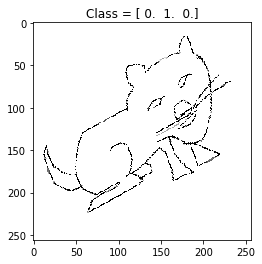

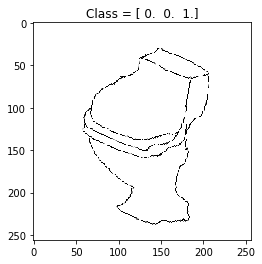

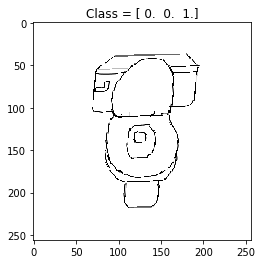

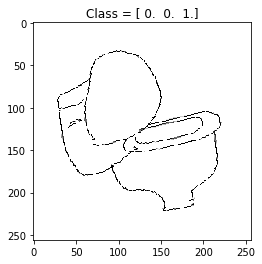

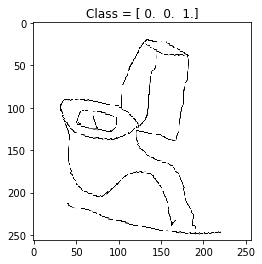

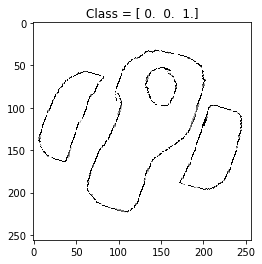

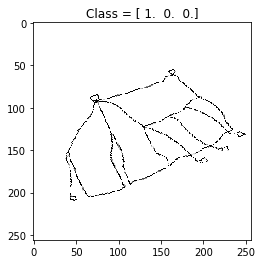

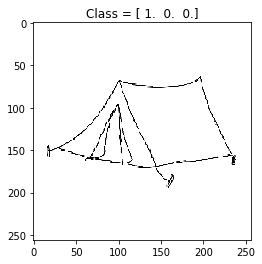

In [6]:
for X_batch, Y_batch in train_generator:
    print X_batch.shape, Y_batch.shape
#     plots(X_batch[:12,:,:,:], figsize=(12,12), rows=3)
    for i in range(len(Y_batch)):
        show_sample(X_batch[i, :, :, :], Y_batch[i])
        if i > 6:
            break
    break

In [7]:
model_name = 'sketchnet1'
%mkdir -p logs/{model_name}
%mkdir -p models/{model_name}

tensorboard_callback =\
    TensorBoard(log_dir='./logs/'+model_name+'/', 
                histogram_freq=0, 
                write_graph=False, write_images=False)
checkpoint_callback =\
    ModelCheckpoint('./models/'+model_name+'.h5', 
                    monitor='val_acc', verbose=0, 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode='auto', period=1)

In [8]:
# now try training a simple convnet
model = Sequential()
model.add(Convolution2D(64, (3, 3), 
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_height, channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3), 
                        padding='same', 
                        activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))

model.add(Convolution2D(256, (3, 3), 
                        padding='same', 
                        activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [ ]:
total_epochs=0

In [10]:
nb_epoch = 1
K.set_value(opt.lr, 0.0001)

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 6,
        epochs = nb_epoch,
        validation_data = validation_generator,
        validation_steps = 2,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)
total_epochs += nb_epoch

Epoch 1/1
6/6 [==============================] - 37s - loss: 1.2298 - acc: 0.2500 - val_loss: 1.1177 - val_acc: 0.2500


In [11]:
# set higher learning rate and train for more epochs:
K.set_value(opt.lr, 0.001)

nb_epoch = 25

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 18, # 180 train samples
        epochs = nb_epoch,
        validation_data = validation_generator,
        validation_steps = 6, # 60 test samples
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)
total_epochs += nb_epoch

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=1, validation_data=<keras.pre..., steps_per_epoch=6, epochs=25, callbacks=[<keras.ca..., validation_steps=2)`
  app.launch_new_instance()


Epoch 1/25
6/6 [==============================] - 42s - loss: 1.4504 - acc: 0.4000 - val_loss: 1.0978 - val_acc: 0.4000
Epoch 2/25
6/6 [==============================] - 43s - loss: 1.1245 - acc: 0.3000 - val_loss: 1.0952 - val_acc: 0.4500
Epoch 3/25
6/6 [==============================] - 38s - loss: 1.6338 - acc: 0.2833 - val_loss: 1.0999 - val_acc: 0.2500
Epoch 4/25
6/6 [==============================] - 38s - loss: 1.1213 - acc: 0.2833 - val_loss: 1.7997 - val_acc: 0.1500
Epoch 5/25
6/6 [==============================] - 43s - loss: 1.1725 - acc: 0.2500 - val_loss: 1.0531 - val_acc: 0.5000
Epoch 6/25
6/6 [==============================] - 39s - loss: 1.1464 - acc: 0.3500 - val_loss: 1.1809 - val_acc: 0.3000
Epoch 7/25
6/6 [==============================] - 38s - loss: 1.1772 - acc: 0.3167 - val_loss: 1.0923 - val_acc: 0.4000
Epoch 8/25
6/6 [==============================] - 38s - loss: 1.2805 - acc: 0.3167 - val_loss: 1.0959 - val_acc: 0.3000
Epoch 9/25
6/6 [========================

In [16]:
metrics = model.evaluate_generator(validation_generator, steps=6)
print model.metrics_names, metrics

['loss', 'acc'] [0.68547658125559485, 0.76666666070620215]


In [18]:
# now try with batchnorm:
# now try training a simple convnet
def build_model2():
    model = Sequential()
#     model.add(BatchNormalization(input_shape=(img_width, img_height, channels)))
    model.add(Convolution2D(64, (3, 3), 
                            padding='same',
                            input_shape=(img_width, img_height, channels)))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3, 3), 
                            padding='same'))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.125))

    model.add(Convolution2D(256, (3, 3), 
                            padding='same'))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
#     model.add(BatchNormalization())
    model.add(Activation('softmax'))

    # initialize optimizer
    opt = rmsprop(lr=0.0001)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model, opt

# tf.reset_default_graph()
model_bn, opt_bn = build_model2()

In [19]:
# set up logging
model_name = 'sketchnet1_bn'
%mkdir -p logs/{model_name}
%mkdir -p models/{model_name}

tensorboard_callback =\
    TensorBoard(log_dir='./logs/'+model_name+'/', 
                histogram_freq=0, 
                write_graph=False, write_images=False)
checkpoint_callback =\
    ModelCheckpoint('./models/'+model_name+'.h5', 
                    monitor='val_acc', verbose=0, 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode='auto', period=1)

In [20]:
total_epochs = 0

In [21]:
nb_epoch = 1
K.set_value(opt_bn.lr, 0.0001)

hist = model_bn.fit_generator(
        train_generator,
        steps_per_epoch = 18,
        epochs = nb_epoch,
        validation_data = validation_generator,
        validation_steps = 6,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)
total_epochs += nb_epoch

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder_2:0", shape=(), dtype=float32) is not an element of this graph.

In [8]:
# set higher learning rate and train for more epochs:
K.set_value(opt_bn.lr, 0.001)

nb_epoch = 10

hist = model_bn.fit_generator(
        train_generator,
        steps_per_epoch = 18, # 180 train samples
        epochs = total_epochs+nb_epoch,
        validation_data = validation_generator,
        validation_steps = 6, # 60 test samples
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)
total_epochs += nb_epoch

Epoch 2/11
18/18 [==============================] - 6s - loss: 0.8106 - acc: 0.6278 - val_loss: 5.2840 - val_acc: 0.3333
Epoch 3/11
18/18 [==============================] - 6s - loss: 0.7234 - acc: 0.7111 - val_loss: 7.6435 - val_acc: 0.4167
Epoch 4/11
18/18 [==============================] - 6s - loss: 0.6241 - acc: 0.7778 - val_loss: 6.7020 - val_acc: 0.3333
Epoch 5/11
18/18 [==============================] - 6s - loss: 0.6959 - acc: 0.7111 - val_loss: 10.0845 - val_acc: 0.2500
Epoch 6/11
18/18 [==============================] - 6s - loss: 0.6896 - acc: 0.7056 - val_loss: 5.4805 - val_acc: 0.3167
Epoch 7/11
18/18 [==============================] - 6s - loss: 0.6781 - acc: 0.7167 - val_loss: 5.5127 - val_acc: 0.3333
Epoch 8/11
18/18 [==============================] - 11s - loss: 0.7054 - acc: 0.7556 - val_loss: 0.8192 - val_acc: 0.6500
Epoch 9/11
18/18 [==============================] - 6s - loss: 0.6108 - acc: 0.7611 - val_loss: 3.0045 - val_acc: 0.4000
Epoch 10/11
18/18 [===========

In [30]:
metrics = model_bn.evaluate_generator(train_generator, steps=6)
print 'val', model_bn.metrics_names, metrics
metrics = model_bn.evaluate_generator(validation_generator, steps=6)
print 'val', model_bn.metrics_names, metrics

val ['loss', 'acc'] [1.28944996992747, 0.41666667660077411]
val ['loss', 'acc'] [1.1715052574872971, 0.50000001738468802]


In [6]:
model_bn.load_weights('models/sketchnet1_bn.h5')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


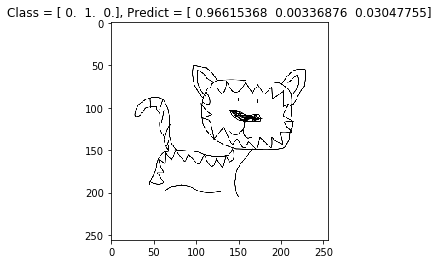

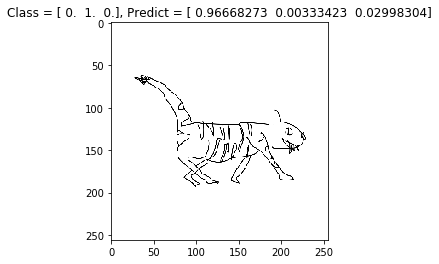

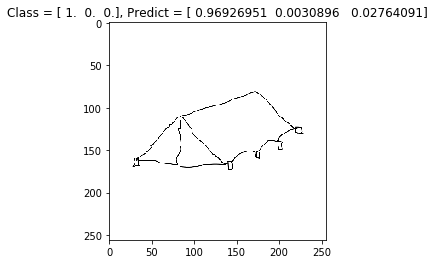

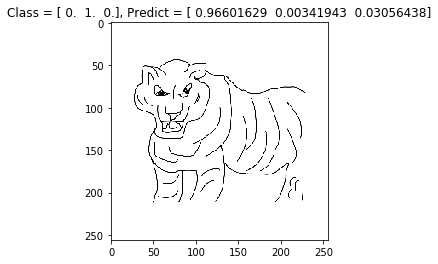

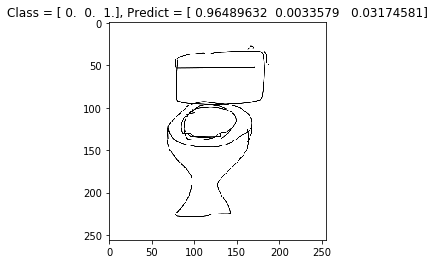

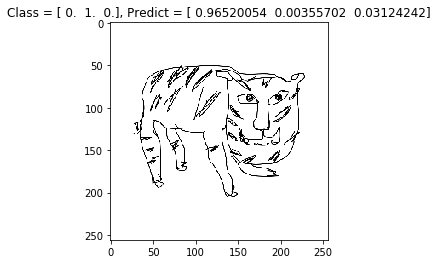

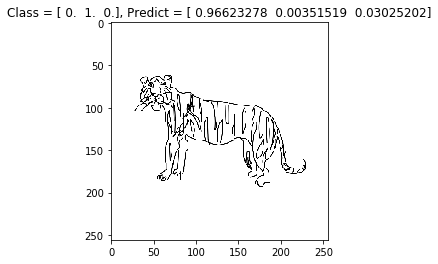

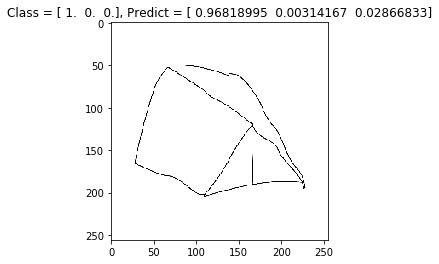

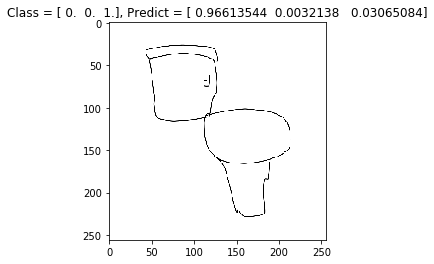

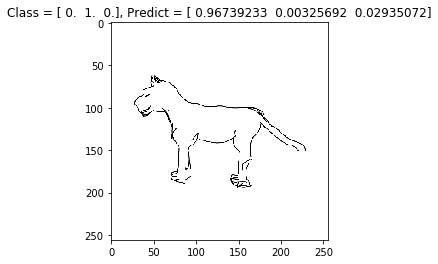

In [12]:
# load model and display some predictions
X_batch, y_batch = validation_generator.next()
y_pred = model_bn.predict(X_batch)
for i in range(y_batch.shape[0]):
    show_sample(X_batch[i], y_batch[i], y_pred[i])

In [24]:
# ok batchnorm working now make larger model and train on full dataset
# now try with batchnorm:
# now try training a simple convnet
def build_sketchnet1():
    model = Sequential()
    model.add(Convolution2D(64, (3, 3), 
                            padding='same',
                            input_shape=(img_width, img_height, channels)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3, 3), 
                            padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.125))
    
    model.add(Convolution2D(256, (3, 3), 
                            padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(256, (3, 3), 
                            padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(2056))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2056))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))

    # initialize optimizer
    opt = rmsprop(lr=0.0001)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

sketchnet1 = build_sketchnet1()

In [ ]:
batch_size = 10

data_root = 'data/tu-berlin/sample/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

batch, y = train_generator.next()
img_height = batch.shape[1]
img_width = batch.shape[2]
channels = batch.shape[3]
num_classes = len(y[0])
print img_height, img_width, channels, num_classes